## focal loss model

dataset:
    https://www.kaggle.com/ealaxi/paysim1

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from focal_loss import BinaryFocalLoss
np.random.seed(42)

2024-06-07 01:35:03.935498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# create data frame containing your data, each column can be accessed # by df['column   name']
dataset = pd.read_csv('./creditcard.csv')

dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
dataset['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [70]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [54]:
y_test

169876     1.79
127467     1.98
137900     0.89
21513     15.98
134700     0.76
          ...  
230213     1.29
275519    29.24
148273    44.91
77261     19.37
73202      0.81
Name: Amount, Length: 56962, dtype: float64

In [58]:
X_test

array([[ 1.3886888 , -0.34434507,  0.8527222 , ...,  1.32258469,
         0.88256448, -0.26127341],
       [-1.57864641, -1.44474752, -1.67452292, ...,  0.27451198,
        -1.55093908, -0.30585207],
       [-0.13662085, -1.82596047,  1.40399293, ...,  1.36860161,
         1.54435108, -0.04909498],
       ...,
       [ 1.50050637, -0.53491142,  0.41490872, ...,  0.04297833,
         0.43968751, -0.28770076],
       [ 1.45247325,  1.10276226, -0.65659184, ..., -0.00635543,
        -0.17197637, -0.27346757],
       [-0.92136544,  0.62697885, -0.36532556, ...,  0.06142974,
         0.15200374, -0.11374403]])

In [71]:
import tensorflow as tf
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        focal_loss = -self.alpha * (y_true * (1.0 - y_pred) ** self.gamma * tf.math.log(y_pred) +
                                   (1.0 - y_true) * y_pred ** self.gamma * tf.math.log(1.0 - y_pred))
        return tf.reduce_mean(focal_loss)

In [72]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

input_layer = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with Focal Loss
model.compile(optimizer='nadam', loss=FocalLoss(), metrics=[tf.keras.metrics.Precision()])

In [73]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


In [62]:
y_train.shape

(227845,)

In [75]:
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2849/2849 [==============================] - 31s 11ms/step - loss: 3.3442e-04 - precision: 0.8594 - val_loss: 3.1902e-04 - val_precision: 0.8481
Epoch 2/10
2849/2849 [==============================] - 32s 11ms/step - loss: 2.4523e-04 - precision: 0.8593 - val_loss: 2.6471e-04 - val_precision: 0.8701
Epoch 3/10
2849/2849 [==============================] - 29s 10ms/step - loss: 2.0492e-04 - precision: 0.8504 - val_loss: 2.9619e-04 - val_precision: 0.9275
Epoch 4/10
2849/2849 [==============================] - 31s 11ms/step - loss: 1.9359e-04 - precision: 0.8810 - val_loss: 2.7055e-04 - val_precision: 0.8356
Epoch 5/10
2849/2849 [==============================] - 33s 11ms/step - loss: 1.6399e-04 - precision: 0.9011 - val_loss: 3.0123e-04 - val_precision: 0.8701
Epoch 6/10
2849/2849 [==============================] - 32s 11ms/step - loss: 1.4752e-04 - precision: 0.8794 - val_loss: 3.2920e-04 - val_precision: 0.9167
Epoch 7/10
2849/2849 [==============================] - 30s 11ms

In [76]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

1781/1781 [==============================] - 8s 4ms/step


In [78]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9992
Precision: 0.8750
Recall: 0.6429
F1 Score: 0.7412


In [79]:
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[56855     9]
 [   35    63]]


In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

LABELS = ['Normal','Fraud'] 

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

ValueError: Must pass 2-d input. shape=()

<Figure size 500x500 with 0 Axes>

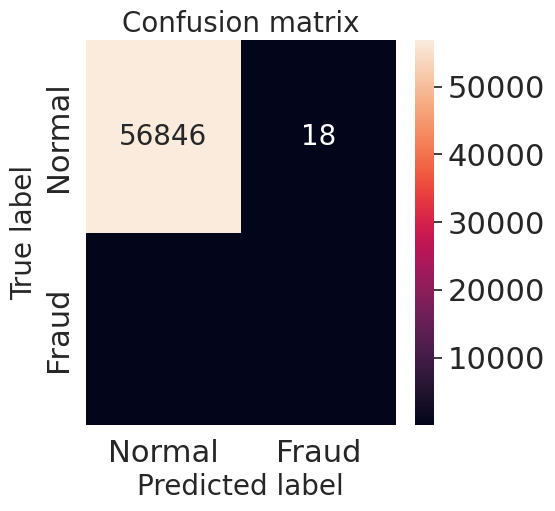

In [68]:

confusion_matrix = metrics.confusion_matrix(y_test.values, binary_predictions)
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

### Total miss-classified labels

In [69]:
values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)
error_count

40

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score